In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ================================================
# 🧠 ARTICULATORY DECODER — CLEAN VERSION (PATH A)
# ================================================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to your dataset
ARTIC_DIR = "/content/drive/MyDrive/EEG_Speech_Dataset/Articulatory"
GENERAL_DIR = "/content/drive/MyDrive/EEG_Speech_Dataset/General"


Using device: cuda


In [ ]:
!ls /content/drive/MyDrive/EEG_Speech_Dataset/


Acoustic  Articulatory	General  models  Models  Semantic


In [ ]:
# ================================
# CELL 1 — Load channel counts
# ================================
import numpy as np
import pandas as pd
import os

ARTIC_DIR = "/content/drive/MyDrive/EEG_Speech_Dataset/Articulatory"
GENERAL_DIR = "/content/drive/MyDrive/EEG_Speech_Dataset/General"

# Load channel count for every subject
channel_counts = {}
for f in os.listdir(GENERAL_DIR):
    if f.endswith("_channel_names.npy"):
        sub = f.replace("_channel_names.npy", "")
        ch = np.load(os.path.join(GENERAL_DIR, f))
        channel_counts[sub] = len(ch)

print("Loaded channel counts:")
for k,v in channel_counts.items():
    print(k, "→", v)


Loaded channel counts:
sub-05 → 60
sub-15 → 65
sub-06 → 127
sub-08 → 54
sub-07 → 127
sub-03 → 127
sub-02 → 127
sub-01 → 127
sub-11 → 68
sub-10 → 122
sub-14 → 127
sub-09 → 117
sub-13 → 157
sub-04 → 115
sub-12 → 127


Dataset Class for Articulatory Autoencoder

 Loads EEG (reshaped to (N, 9, channels))
 Loads articulatory trajectories (Y: (N, 20))
 Automatically aligns lengths
 Converts everything to torch tensors
 Keeps it extremely clean and reusable

In [ ]:
import numpy as np

# Pick a subject
sub = "sub-01"

# Load EEG features
eeg = np.load(f"{ARTIC_DIR}/{sub}_features.npy").astype(np.float32)

# Load articulatory trajectories (20 dims)
traj = pd.read_csv(f"{ARTIC_DIR}/{sub}_trajectories.csv").values[:,1:].astype(np.float32)

# Align lengths
L = min(len(eeg), len(traj))
eeg = eeg[:L]
traj = traj[:L]

# Number of channels
channels = channel_counts[sub]
print("Channels =", channels)

# Number of frames (should be 9)
frames = eeg.shape[1] // channels
print("Frames =", frames)
assert frames == 9, "Unexpected frame count!"

# Reshape EEG → (N, 9, C)
eeg = eeg.reshape(L, frames, channels)
print("EEG shape:", eeg.shape)
print("Traj shape:", traj.shape)


Channels = 127
Frames = 9
EEG shape: (29581, 9, 127)
Traj shape: (29581, 20)


In [ ]:
# ========================================
# CELL 2 — Articulatory Dataset
# ========================================
import torch
from torch.utils.data import Dataset

class ArticulatoryDataset(Dataset):
    def __init__(self, sub_id):
        # Load EEG
        eeg_path = f"{ARTIC_DIR}/{sub_id}_features.npy"
        eeg = np.load(eeg_path).astype(np.float32)

        # Load trajectories
        traj_path = f"{ARTIC_DIR}/{sub_id}_trajectories.csv"
        traj = pd.read_csv(traj_path).values[:, 1:].astype(np.float32)

        # Align lengths
        L = min(len(eeg), len(traj))
        eeg, traj = eeg[:L], traj[:L]

        # Subject-specific channels
        ch = channel_counts[sub_id]
        frames = eeg.shape[1] // ch
        assert frames == 9, f"Expected 9 frames, got {frames}"

        # Reshape EEG: (N, 9, C)
        eeg = eeg.reshape(L, frames, ch)

        self.X = torch.tensor(eeg, dtype=torch.float32)
        self.Y = torch.tensor(traj, dtype=torch.float32)

        print(f"[{sub_id}] Loaded dataset → X:{self.X.shape}, Y:{self.Y.shape}")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


Articulatory Encoder (TCN → BiLSTM → Transformer → 256-D Embedding)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# --------------------------
# Positional Encoding (same as acoustic)
# --------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=128):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len].to(x.device)


# -------------------------------------------------------------------
# 🌟 Articulatory Encoder — TCN → BiLSTM → Transformer → Two Heads
# -------------------------------------------------------------------
class ArticulatoryEncoder(nn.Module):
    def __init__(self, n_channels, hidden=256, lstm_hidden=256, emb_dim=256):
        super().__init__()

        # ===============================
        # 1) TEMPORAL CNN (TCN extraction)
        # ===============================
        self.tcn = nn.Sequential(
            nn.Conv1d(n_channels, hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # Output shape: (B, hidden, 9)

        # ===============================
        # 2) BiLSTM
        # ===============================
        self.bilstm = nn.LSTM(
            input_size=hidden,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        # Output: (B, 9, 2*lstm_hidden)

        # ===============================
        # 3) Transformer Encoder
        # ===============================
        t_hidden = lstm_hidden * 2

        self.pos = PositionalEncoding(t_hidden)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=t_hidden,
            nhead=8,
            dim_feedforward=t_hidden * 4,
            batch_first=True,
            dropout=0.1
        )

        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)

        # ===============================
        # 4) TWO HEADS
        # ===============================

        # (A) Embedding head → for multimodal fusion
        self.emb_head = nn.Linear(t_hidden, emb_dim)

        # (B) Reconstruction head → predict 20 articulatory dims
        self.recon_head = nn.Sequential(
            nn.Linear(t_hidden, 128),
            nn.ReLU(),
            nn.Linear(128, 20)
        )

    def forward(self, x):
        # x: (B, 9, C)

        # --------------------------------
        # 1) TCN expects (B, C, 9)
        # --------------------------------
        x = x.permute(0, 2, 1)
        x = self.tcn(x)               # → (B, hidden, 9)

        # --------------------------------
        # 2) BiLSTM expects (B, 9, hidden)
        # --------------------------------
        x = x.permute(0, 2, 1)
        x, _ = self.bilstm(x)         # → (B, 9, 2*lstm_hidden)

        # --------------------------------
        # 3) Transformer encoder
        # --------------------------------
        x = self.pos(x)
        x = self.transformer(x)       # → (B, 9, t_hidden)

        # center frame representation (index 4)
        center = x[:, 4, :]           # (B, t_hidden)

        # --------------------------------
        # 4) Two heads
        # --------------------------------
        emb = self.emb_head(center)       # (B, 256)
        recon = self.recon_head(center)   # (B, 20)

        return emb, recon


In [ ]:
# ==========================================================
# 📌 ARTICULATORY DATASET + LOADERS (FINAL CLEAN VERSION)
# ==========================================================
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os

ARTIC_DIR = "/content/drive/MyDrive/EEG_Speech_Dataset/Articulatory"
GENERAL_DIR = "/content/drive/MyDrive/EEG_Speech_Dataset/General"

# ----------------------------------------------------------
# 1) Load channel counts for all subjects
# ----------------------------------------------------------
channel_counts = {}
for f in os.listdir(GENERAL_DIR):
    if f.endswith("_channel_names.npy"):
        sub = f.replace("_channel_names.npy", "")
        channel_counts[sub] = len(np.load(os.path.join(GENERAL_DIR, f)))

print("Loaded channel counts:")
for k, v in channel_counts.items():
    print(f"{k} → {v}")


# ----------------------------------------------------------
# 2) Dataset class
# X = (N, 9, Channels)
# Y = (N, 20)
# ----------------------------------------------------------
class ArticulatoryDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

        print(f"[DATASET] X: {self.X.shape}, Y: {self.Y.shape}")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# ----------------------------------------------------------
# 3) Loader creation function
# ----------------------------------------------------------
def create_loaders(sub_id, batch_size=64, val_split=0.1):

    print("\n=======================================")
    print(f"📥 Loading subject: {sub_id}")
    print("=======================================\n")

    # Load channels for this subject
    if sub_id not in channel_counts:
        raise ValueError(f"No channel count found for {sub_id}")

    C = channel_counts[sub_id]

    # Load EEG features
    eeg_file = f"{ARTIC_DIR}/{sub_id}_features.npy"
    if not os.path.exists(eeg_file):
        raise FileNotFoundError(f"EEG file not found for {sub_id}")

    eeg = np.load(eeg_file).astype(np.float32)

    # Validate frames (should be 9)
    if eeg.shape[1] % C != 0:
        raise ValueError(f"EEG feature mismatch for {sub_id}: {eeg.shape}")

    frames = eeg.shape[1] // C
    if frames != 9:
        print(f"⚠ WARNING: Expected 9 frames, found {frames}")

    # Reshape EEG → (N, 9, C)
    eeg = eeg.reshape(len(eeg), frames, C)

    # Load articulatory trajectories
    traj_file = f"{ARTIC_DIR}/{sub_id}_trajectories.csv"
    Y = pd.read_csv(traj_file).values[:, 1:].astype(np.float32)

    # Align sequence lengths
    L = min(len(eeg), len(Y))
    eeg, Y = eeg[:L], Y[:L]

    print(f"[{sub_id}] Final EEG shape: {eeg.shape}")
    print(f"[{sub_id}] Final Traj shape: {Y.shape}")

    # Build dataset
    dataset = ArticulatoryDataset(eeg, Y)

    # Train/val split
    val_len = int(val_split * len(dataset))
    train_len = len(dataset) - val_len

    train_ds, val_ds = random_split(dataset, [train_len, val_len])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size)

    print(f"✔ Train batches: {len(train_loader)}")
    print(f"✔ Val batches  : {len(val_loader)}")

    return train_loader, val_loader


Loaded channel counts:
sub-05 → 60
sub-15 → 65
sub-06 → 127
sub-08 → 54
sub-07 → 127
sub-03 → 127
sub-02 → 127
sub-01 → 127
sub-11 → 68
sub-10 → 122
sub-14 → 127
sub-09 → 117
sub-13 → 157
sub-04 → 115
sub-12 → 127


In [ ]:
train_loader, val_loader = create_loaders("sub-01")

xb, yb = next(iter(train_loader))
print("EEG batch:", xb.shape)   # → (B, 9, Channels)
print("Traj batch:", yb.shape)  # → (B, 20)



📥 Loading subject: sub-01

[sub-01] Final EEG shape: (29581, 9, 127)
[sub-01] Final Traj shape: (29581, 20)
[DATASET] X: torch.Size([29581, 9, 127]), Y: torch.Size([29581, 20])
✔ Train batches: 416
✔ Val batches  : 47
EEG batch: torch.Size([64, 9, 127])
Traj batch: torch.Size([64, 20])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd


In [ ]:
class ArticulatoryDataset(Dataset):
    def __init__(self, eeg, traj):
        self.eeg = torch.tensor(eeg, dtype=torch.float32)   # (N, 9, C)
        self.traj = torch.tensor(traj, dtype=torch.float32) # (N, 20)

    def __len__(self):
        return len(self.eeg)

    def __getitem__(self, idx):
        return self.eeg[idx], self.traj[idx]



In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)

        div = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)

        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


In [ ]:
class ArticulatoryEncoder(nn.Module):
    def __init__(self, n_channels, hidden=256, lstm_hidden=256, emb_dim=256):
        super().__init__()

        # ------------ 1) TCN ------------
        self.tcn = nn.Sequential(
            nn.Conv1d(n_channels, hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # ------------ 2) BiLSTM ------------
        self.lstm = nn.LSTM(
            input_size=hidden,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # ------------ 3) Transformer ------------
        self.pos = PositionalEncoding(lstm_hidden * 2)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=lstm_hidden * 2,
            nhead=8,
            dim_feedforward=1024,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # ------------ 4) Two Heads ------------
        # Regression head → 20 articulatory dims
        self.head_traj = nn.Sequential(
            nn.Linear(lstm_hidden * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 20)
        )

        # Embedding head → 256-dim fusion vector
        self.head_emb = nn.Linear(lstm_hidden * 2, emb_dim)

    def forward(self, x):
        # x: (B, 9, C)
        x = x.transpose(1, 2)            # → (B, C, 9)

        # ---- TCN ----
        x = self.tcn(x)                  # (B, hidden, 9)

        # ---- LSTM ----
        x = x.transpose(1, 2)            # (B, 9, hidden)
        lstm_out, _ = self.lstm(x)       # (B, 9, 2*lstm_hidden)

        # ---- Transformer ----
        x = self.pos(lstm_out)
        x = self.transformer(x)          # (B, 9, 2*lstm_hidden)

        # ---- Use center timestep ----
        center = x[:, 4, :]              # timestep index 4 out of 0..8

        # ---- Heads ----
        traj = self.head_traj(center)    # (B, 20)
        emb  = self.head_emb(center)     # (B, 256)

        return traj, emb


In [ ]:
sub = "sub-01"

eeg = np.load(f"{ARTIC_DIR}/{sub}_features.npy").astype(np.float32)
traj = pd.read_csv(f"{ARTIC_DIR}/{sub}_trajectories.csv").values[:, 1:].astype(np.float32)

channels = channel_counts[sub]
frames = eeg.shape[1] // channels
assert frames == 9, "Incorrect number of timeframes!"

# reshape (N, 9, C)
eeg = eeg.reshape(len(eeg), frames, channels)

dataset = ArticulatoryDataset(eeg, traj)

train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ArticulatoryEncoder(n_channels=channels).to(device)

loss_fn = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 20

for ep in range(EPOCHS):
    model.train()
    train_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optim.zero_grad()
        pred, emb = model(x)

        loss = loss_fn(pred, y)
        loss.backward()
        optim.step()

        train_loss += loss.item() * len(x)

    train_loss /= train_len

    # ---- validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred, emb = model(x)
            val_loss += loss_fn(pred, y).item() * len(x)
    val_loss /= val_len

    print(f"Epoch {ep+1}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")


Epoch 1/20 | Train Loss: 0.169107 | Val Loss: 0.048494
Epoch 2/20 | Train Loss: 0.047011 | Val Loss: 0.044518
Epoch 3/20 | Train Loss: 0.042519 | Val Loss: 0.039986
Epoch 4/20 | Train Loss: 0.039374 | Val Loss: 0.038564
Epoch 5/20 | Train Loss: 0.036742 | Val Loss: 0.032568
Epoch 6/20 | Train Loss: 0.031687 | Val Loss: 0.032177
Epoch 7/20 | Train Loss: 0.026660 | Val Loss: 0.023786
Epoch 8/20 | Train Loss: 0.021762 | Val Loss: 0.023326
Epoch 9/20 | Train Loss: 0.018516 | Val Loss: 0.016897
Epoch 10/20 | Train Loss: 0.016452 | Val Loss: 0.016496
Epoch 11/20 | Train Loss: 0.013652 | Val Loss: 0.013059
Epoch 12/20 | Train Loss: 0.011450 | Val Loss: 0.011189
Epoch 13/20 | Train Loss: 0.010278 | Val Loss: 0.009665
Epoch 14/20 | Train Loss: 0.008472 | Val Loss: 0.009059
Epoch 15/20 | Train Loss: 0.007648 | Val Loss: 0.011198
Epoch 16/20 | Train Loss: 0.007181 | Val Loss: 0.008507
Epoch 17/20 | Train Loss: 0.007063 | Val Loss: 0.007113
Epoch 18/20 | Train Loss: 0.005531 | Val Loss: 0.006193
E

In [ ]:
import numpy as np
import torch

model.eval()
true_vals = []
pred_vals = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb)[0]   # trajectory head
        true_vals.append(yb.numpy())
        pred_vals.append(preds.cpu().numpy())

true_vals = np.concatenate(true_vals, axis=0)     # (N, 20)
pred_vals = np.concatenate(pred_vals, axis=0)     # (N, 20)

print("Collected predictions:", pred_vals.shape)


Collected predictions: (5917, 20)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# MAE
mae = mean_absolute_error(true_vals, pred_vals)

# MSE (no squared=False)
mse = mean_squared_error(true_vals, pred_vals)

# RMSE = sqrt(MSE)
rmse = np.sqrt(mse)

# R² score
r2 = r2_score(true_vals, pred_vals)

print(f"Overall MAE : {mae:.4f}")
print(f"RMSE        : {rmse:.4f}")
print(f"R² Score    : {r2:.4f}")


Overall MAE : 0.0381
RMSE        : 0.0761
R² Score    : 0.7132


In [ ]:
print("\nPer-dimension MAE:")
for i in range(20):
    dim_mae = mean_absolute_error(true_vals[:, i], pred_vals[:, i])
    print(f"Dim {i:02d}: {dim_mae:.4f}")



Per-dimension MAE:
Dim 00: 0.0078
Dim 01: 0.0110
Dim 02: 0.0297
Dim 03: 0.0269
Dim 04: 0.0936
Dim 05: 0.0115
Dim 06: 0.0752
Dim 07: 0.0241
Dim 08: 0.0325
Dim 09: 0.0266
Dim 10: 0.0167
Dim 11: 0.0556
Dim 12: 0.0411
Dim 13: 0.0647
Dim 14: 0.0536
Dim 15: 0.0721
Dim 16: 0.0614
Dim 17: 0.0196
Dim 18: 0.0125
Dim 19: 0.0264


In [ ]:
import numpy as np

pearsons = []
for i in range(20):
    corr = np.corrcoef(true_vals[:, i], pred_vals[:, i])[0, 1]
    pearsons.append(corr)

print("\nMean Pearson:", np.mean(pearsons))
print("Per-dim Pearson:")
for i, c in enumerate(pearsons):
    print(f"Dim {i:02d}: {c:.4f}")



Mean Pearson: 0.8913331630872463
Per-dim Pearson:
Dim 00: 0.7112
Dim 01: 0.6127
Dim 02: 0.9084
Dim 03: 0.9327
Dim 04: 0.9504
Dim 05: 0.7408
Dim 06: 0.9563
Dim 07: 0.9362
Dim 08: 0.8999
Dim 09: 0.9530
Dim 10: 0.7942
Dim 11: 0.9457
Dim 12: 0.9264
Dim 13: 0.9680
Dim 14: 0.9312
Dim 15: 0.9448
Dim 16: 0.9451
Dim 17: 0.9174
Dim 18: 0.9179
Dim 19: 0.9344


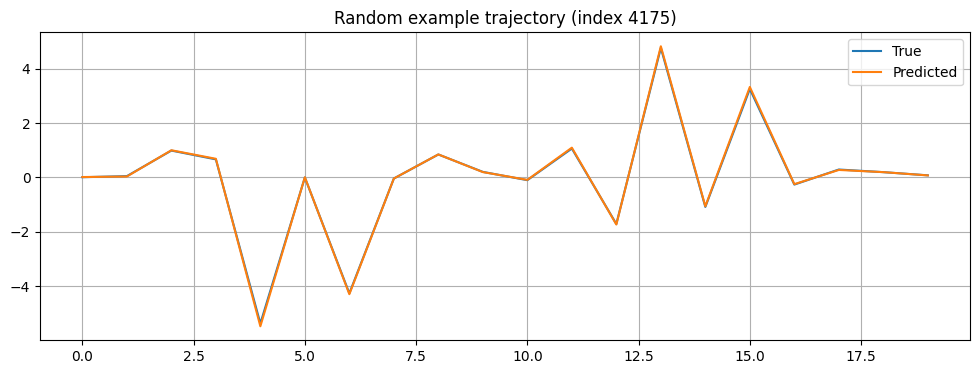

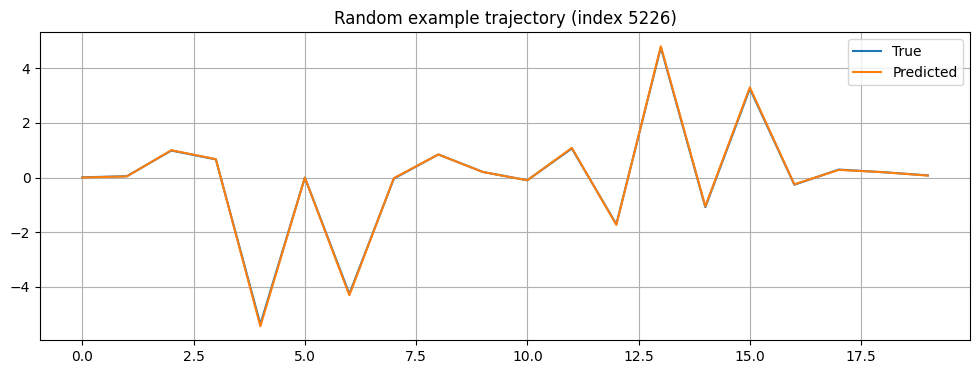

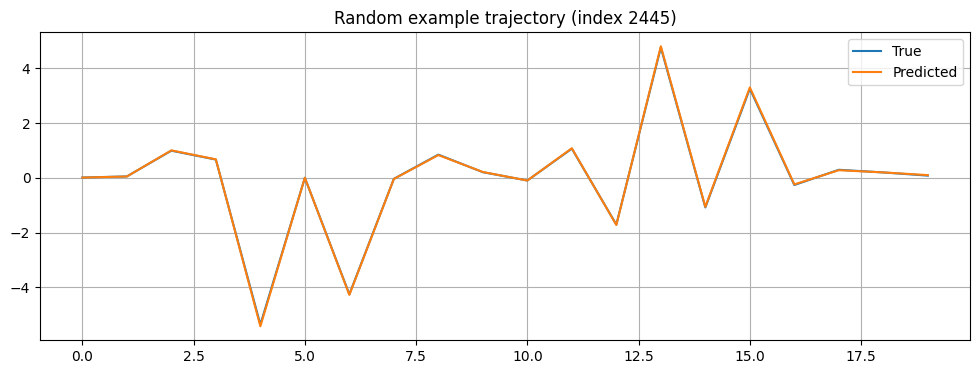

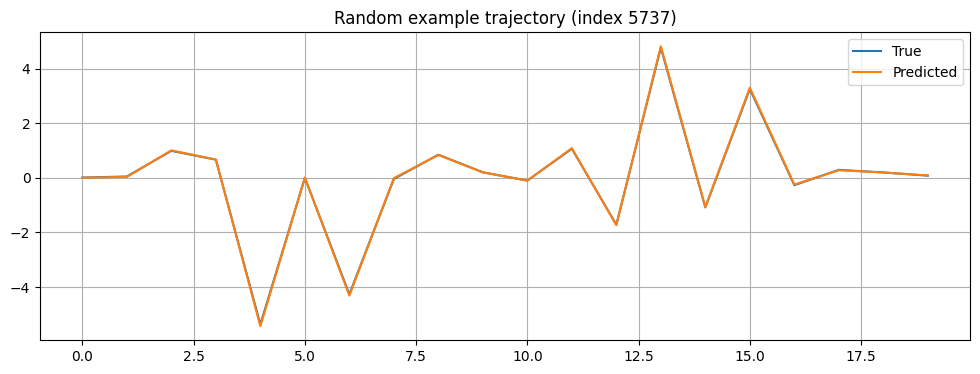

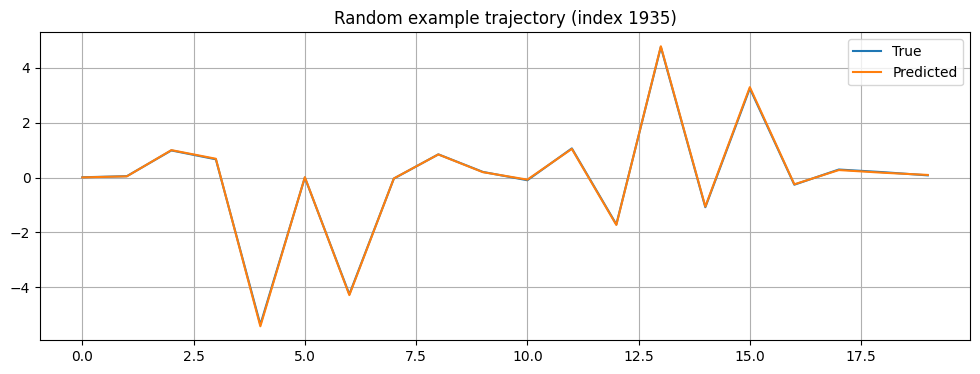

In [ ]:
import matplotlib.pyplot as plt
import random

def plot_random_trajectories(num_plots=5):
    for _ in range(num_plots):
        idx = random.randint(0, len(true_vals)-1)

        plt.figure(figsize=(12,4))
        plt.plot(true_vals[idx], label="True")
        plt.plot(pred_vals[idx], label="Predicted")
        plt.title(f"Random example trajectory (index {idx})")
        plt.legend()
        plt.grid(True)
        plt.show()

plot_random_trajectories()


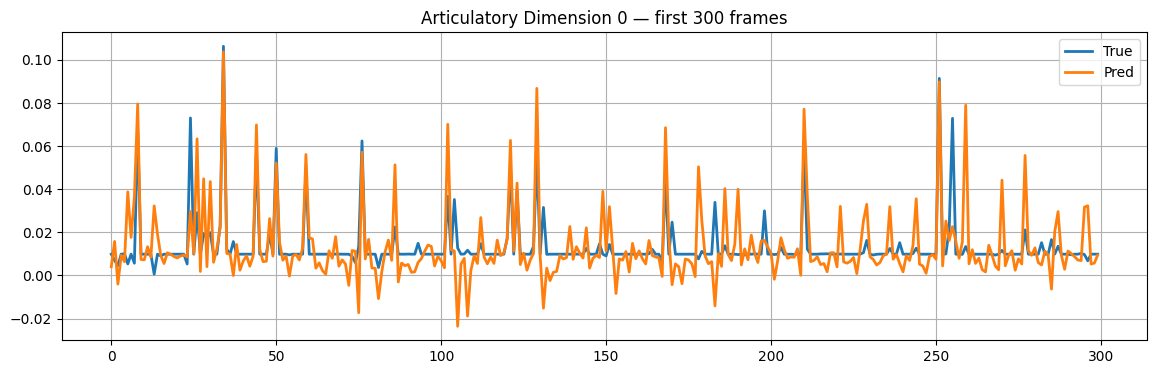

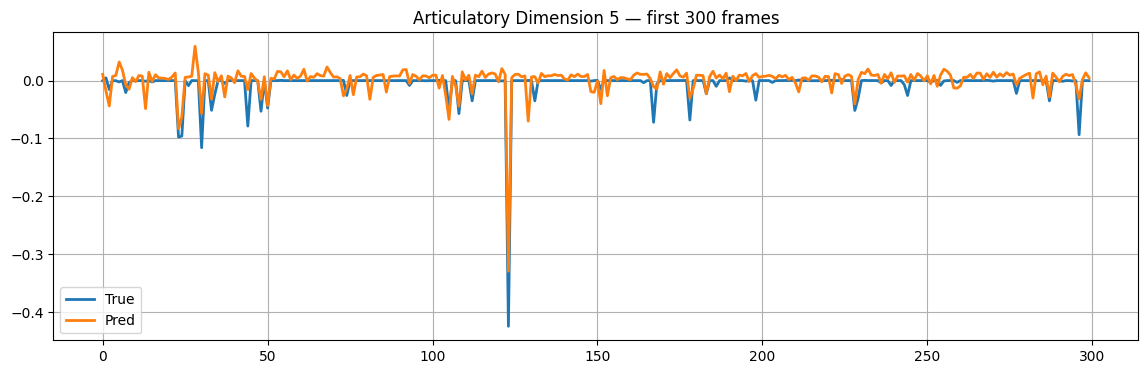

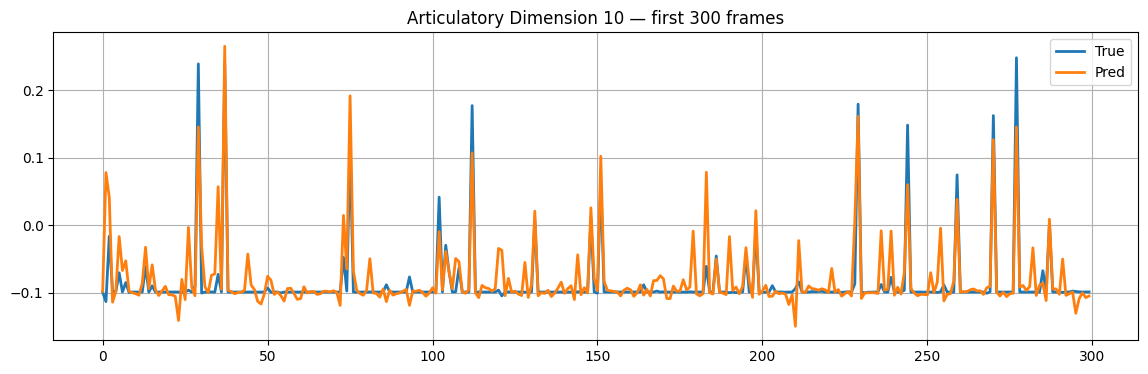

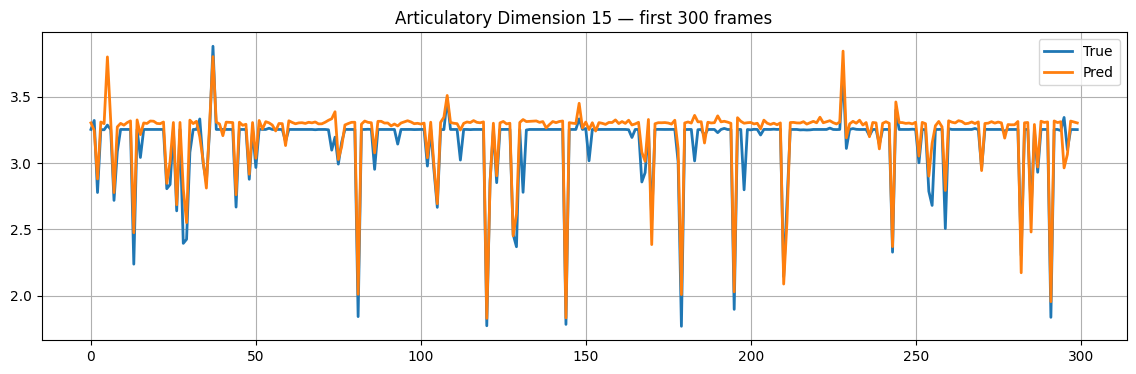

In [ ]:

dims = [0, 5, 10, 15]

for d in dims:
    plt.figure(figsize=(14,4))
    plt.plot(true_vals[:300, d], label="True", linewidth=2)
    plt.plot(pred_vals[:300, d], label="Pred", linewidth=2)
    plt.title(f"Articulatory Dimension {d} — first 300 frames")
    plt.legend()
    plt.grid()
    plt.show()


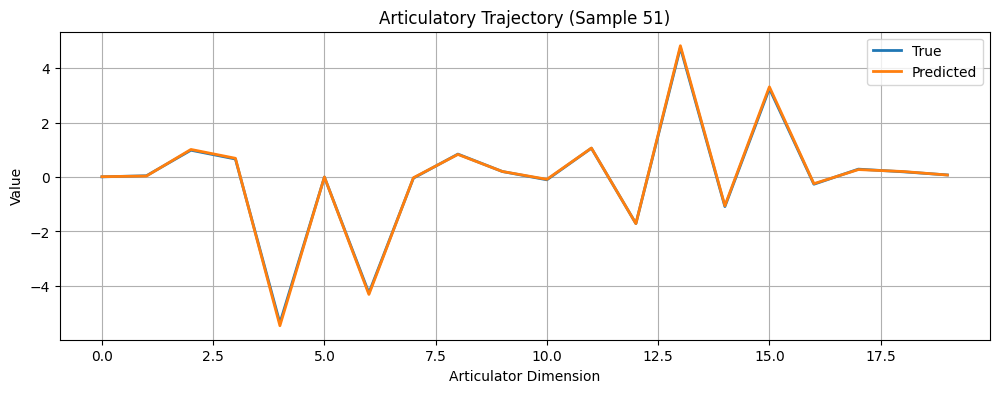

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# get 1 batch
xb, yb = next(iter(val_loader))
xb = xb.to(device)

with torch.no_grad():
    traj_pred, _ = model(xb)

traj_pred = traj_pred.cpu().numpy()
yb = yb.numpy()

idx = random.randint(0, len(yb)-1)

plt.figure(figsize=(12,4))
plt.plot(yb[idx], label="True", linewidth=2)
plt.plot(traj_pred[idx], label="Predicted", linewidth=2)
plt.title(f"Articulatory Trajectory (Sample {idx})")
plt.xlabel("Articulator Dimension")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ================================================
# TRAIN ONE ARTICULATORY ENCODER PER SUBJECT
# ================================================
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ARTIC_DIR = "/content/drive/MyDrive/EEG_Speech_Dataset/Articulatory"


# ---------- Dataset ----------
class ArticDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# ---------- Model ----------
class ArticulatoryEncoder(nn.Module):
    def __init__(self, n_channels, emb_dim=256, hidden=256):
        super().__init__()

        # CNN
        self.conv = nn.Sequential(
            nn.Conv1d(n_channels, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, 3, padding=1),
            nn.ReLU()
        )

        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=hidden,
            hidden_size=hidden,
            batch_first=True,
            bidirectional=True
        )

        # Output heads
        self.to_embedding = nn.Linear(hidden * 2, emb_dim)
        self.to_trajectories = nn.Linear(hidden * 2, 20)

    def forward(self, x):
        # x: (B, 9, C)
        x = x.permute(0, 2, 1)     # → (B, C, 9)
        x = self.conv(x)           # → (B, hidden, 9)

        x = x.permute(0, 2, 1)     # → (B, 9, hidden)
        h, _ = self.lstm(x)        # → (B, 9, 2*hidden)

        pooled = h.mean(dim=1)     # → (B, 2*hidden)

        emb = self.to_embedding(pooled)
        traj = self.to_trajectories(pooled)

        return emb, traj



# =================================================
# TRAINING FUNCTION FOR ONE SUBJECT
# =================================================
def train_articulatory_subject(sub, epochs=10, batch_size=256):
    print(f"\n===================================================")
    print(f"🚀 TRAINING ARTICULATORY ENCODER FOR {sub}")
    print(f"===================================================\n")

    eeg_path = f"{ARTIC_DIR}/{sub}_features.npy"
    traj_path = f"{ARTIC_DIR}/{sub}_trajectories.csv"

    # Safety check
    if not os.path.exists(eeg_path) or not os.path.exists(traj_path):
        print(f"⚠️ Skipping {sub} — missing data files.")
        return None

    eeg = np.load(eeg_path).astype(np.float32)
    traj = pd.read_csv(traj_path).values[:, 1:].astype(np.float32)

    L = min(len(eeg), len(traj))
    eeg, traj = eeg[:L], traj[:L]

    # Determine channel count
    C = channel_counts[sub]
    frames = eeg.shape[1] // C
    assert frames == 9, "Expected 9 frames per EEG timestamp"

    X = eeg.reshape(L, 9, C)  # (N, 9, C)
    Y = traj

    ds = ArticDataset(X, Y)

    val_len = int(0.1 * len(ds))
    train_len = len(ds) - val_len

    train_ds, val_ds = random_split(ds, [train_len, val_len])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    model = ArticulatoryEncoder(n_channels=C).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(1, epochs+1):
        model.train()
        total_train = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            _, pred_traj = model(xb)
            loss = loss_fn(pred_traj, yb)
            loss.backward()
            optimizer.step()

            total_train += loss.item() * len(xb)

        train_loss = total_train / train_len

        # ---- Validation ----
        model.eval()
        total_val = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                _, pred_traj = model(xb)
                total_val += loss_fn(pred_traj, yb).item() * len(xb)

        val_loss = total_val / val_len

        print(f"Epoch {epoch}/{epochs} | Train {train_loss:.4f} | Val {val_loss:.4f}")

    # Save per-subject model
    out_path = f"articulatory_encoder_{sub}.pth"
    torch.save(model.state_dict(), out_path)
    print(f"💾 Saved model to {out_path}\n")

    return model


In [ ]:
for sub in channel_counts.keys():
    train_articulatory_subject(sub, epochs=10)



🚀 TRAINING ARTICULATORY ENCODER FOR sub-05

Epoch 1/10 | Train 0.1853 | Val 0.0596
Epoch 2/10 | Train 0.0605 | Val 0.0603
Epoch 3/10 | Train 0.0603 | Val 0.0595
Epoch 4/10 | Train 0.0586 | Val 0.0564
Epoch 5/10 | Train 0.0556 | Val 0.0543
Epoch 6/10 | Train 0.0541 | Val 0.0529
Epoch 7/10 | Train 0.0533 | Val 0.0522
Epoch 8/10 | Train 0.0517 | Val 0.0600
Epoch 9/10 | Train 0.0520 | Val 0.0586
Epoch 10/10 | Train 0.0515 | Val 0.0588
💾 Saved model to articulatory_encoder_sub-05.pth


🚀 TRAINING ARTICULATORY ENCODER FOR sub-15

Epoch 1/10 | Train 0.1621 | Val 0.0438
Epoch 2/10 | Train 0.0445 | Val 0.0436
Epoch 3/10 | Train 0.0445 | Val 0.0437
Epoch 4/10 | Train 0.0441 | Val 0.0430
Epoch 5/10 | Train 0.0434 | Val 0.0424
Epoch 6/10 | Train 0.0430 | Val 0.0418
Epoch 7/10 | Train 0.0423 | Val 0.0440
Epoch 8/10 | Train 0.0420 | Val 0.0419
Epoch 9/10 | Train 0.0420 | Val 0.0410
Epoch 10/10 | Train 0.0413 | Val 0.0405
💾 Saved model to articulatory_encoder_sub-15.pth


🚀 TRAINING ARTICULATORY ENC

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------
# Compute evaluation metrics
# ------------------------------------------
def evaluate_articulatory(model, val_loader):
    model.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb = Xb.to(device)
            pred = model(Xb).cpu().numpy()
            all_pred.append(pred)
            all_true.append(Yb.numpy())

    y_true = np.vstack(all_true)     # (N, 20)
    y_pred = np.vstack(all_pred)     # (N, 20)

    # --- Metrics ---
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    # Pearson per dimension
    pearsons = []
    for i in range(y_true.shape[1]):
        r, _ = pearsonr(y_true[:, i], y_pred[:, i])
        pearsons.append(r)
    mean_r = np.nanmean(pearsons)

    # Cosine similarity across samples
    cos_sims = []
    for t, p in zip(y_true, y_pred):
        cos = np.dot(t, p) / (np.linalg.norm(t) * np.linalg.norm(p) + 1e-8)
        cos_sims.append(cos)
    cos_sims = np.array(cos_sims)

    # Accuracy within tolerance
    acc_05 = np.mean(np.abs(y_true - y_pred) < 0.05)
    acc_10 = np.mean(np.abs(y_true - y_pred) < 0.10)

    return {
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "pearsons": pearsons,
        "mean_r": mean_r,
        "cosine": np.mean(cos_sims),
        "acc_05": acc_05,
        "acc_10": acc_10
    }


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------------------------------
# Metric computation helper
# ----------------------------------------------------
def compute_articulatory_metrics(preds, trues):
    mae  = mean_absolute_error(trues, preds)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2   = r2_score(trues, preds)

    # Pearson per dimension (20 dims)
    pearsons = []
    for i in range(trues.shape[1]):
        r, _ = pearsonr(trues[:, i], preds[:, i])
        pearsons.append(r)

    mean_r = float(np.nanmean(pearsons))

    # Cosine similarity per-sample
    cos_sims = []
    for t, p in zip(trues, preds):
        cos = np.dot(t, p) / (np.linalg.norm(t) * np.linalg.norm(p) + 1e-8)
        cos_sims.append(cos)

    cos_mean = float(np.mean(cos_sims))

    # Accuracy within tolerance
    acc_05 = float(np.mean(np.abs(trues - preds) < 0.05))
    acc_10 = float(np.mean(np.abs(trues - preds) < 0.10))

    return {
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "mean_pearson": mean_r,
        "pearson_per_dim": pearsons,
        "cosine_similarity": cos_mean,
        "accuracy_±0.05": acc_05,
        "accuracy_±0.10": acc_10
    }

# ----------------------------------------------------
# Main evaluation function
# ----------------------------------------------------
def evaluate_articulatory(model, val_loader):
    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb = Xb.to(device)

            output = model(Xb)

            # 🔥 If model returns (traj_pred, embedding)
            if isinstance(output, tuple):
                output = output[0]

            pred = output.cpu().numpy()
            true = Yb.numpy()

            all_pred.append(pred)
            all_true.append(true)

    preds = np.vstack(all_pred)
    trues = np.vstack(all_true)

    return compute_articulatory_metrics(preds, trues)

# ----------------------------------------------------
# Run evaluation and print results
# ----------------------------------------------------
print("Running articulatory evaluation...")

metrics = evaluate_articulatory(model, val_loader)

print("\n==============================")
print("📊 ARTICULATORY MODEL METRICS")
print("==============================")

for k, v in metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    elif isinstance(v, list):
        print(f"{k}:")
        for i, r in enumerate(v):
            print(f"  dim {i:02d}: {r:.4f}")
    else:
        print(f"{k}: {v}")


Running articulatory evaluation...

📊 ARTICULATORY MODEL METRICS
mae: 0.0381
rmse: 0.0761
r2: 0.7132
mean_pearson: 0.8913
pearson_per_dim:
  dim 00: 0.7112
  dim 01: 0.6127
  dim 02: 0.9084
  dim 03: 0.9327
  dim 04: 0.9504
  dim 05: 0.7408
  dim 06: 0.9563
  dim 07: 0.9362
  dim 08: 0.8999
  dim 09: 0.9530
  dim 10: 0.7942
  dim 11: 0.9457
  dim 12: 0.9264
  dim 13: 0.9680
  dim 14: 0.9312
  dim 15: 0.9448
  dim 16: 0.9451
  dim 17: 0.9174
  dim 18: 0.9179
  dim 19: 0.9344
cosine_similarity: 0.9994
accuracy_±0.05: 0.7900
accuracy_±0.10: 0.9200


Batch shapes → True: (64, 20) Pred: (64, 20)


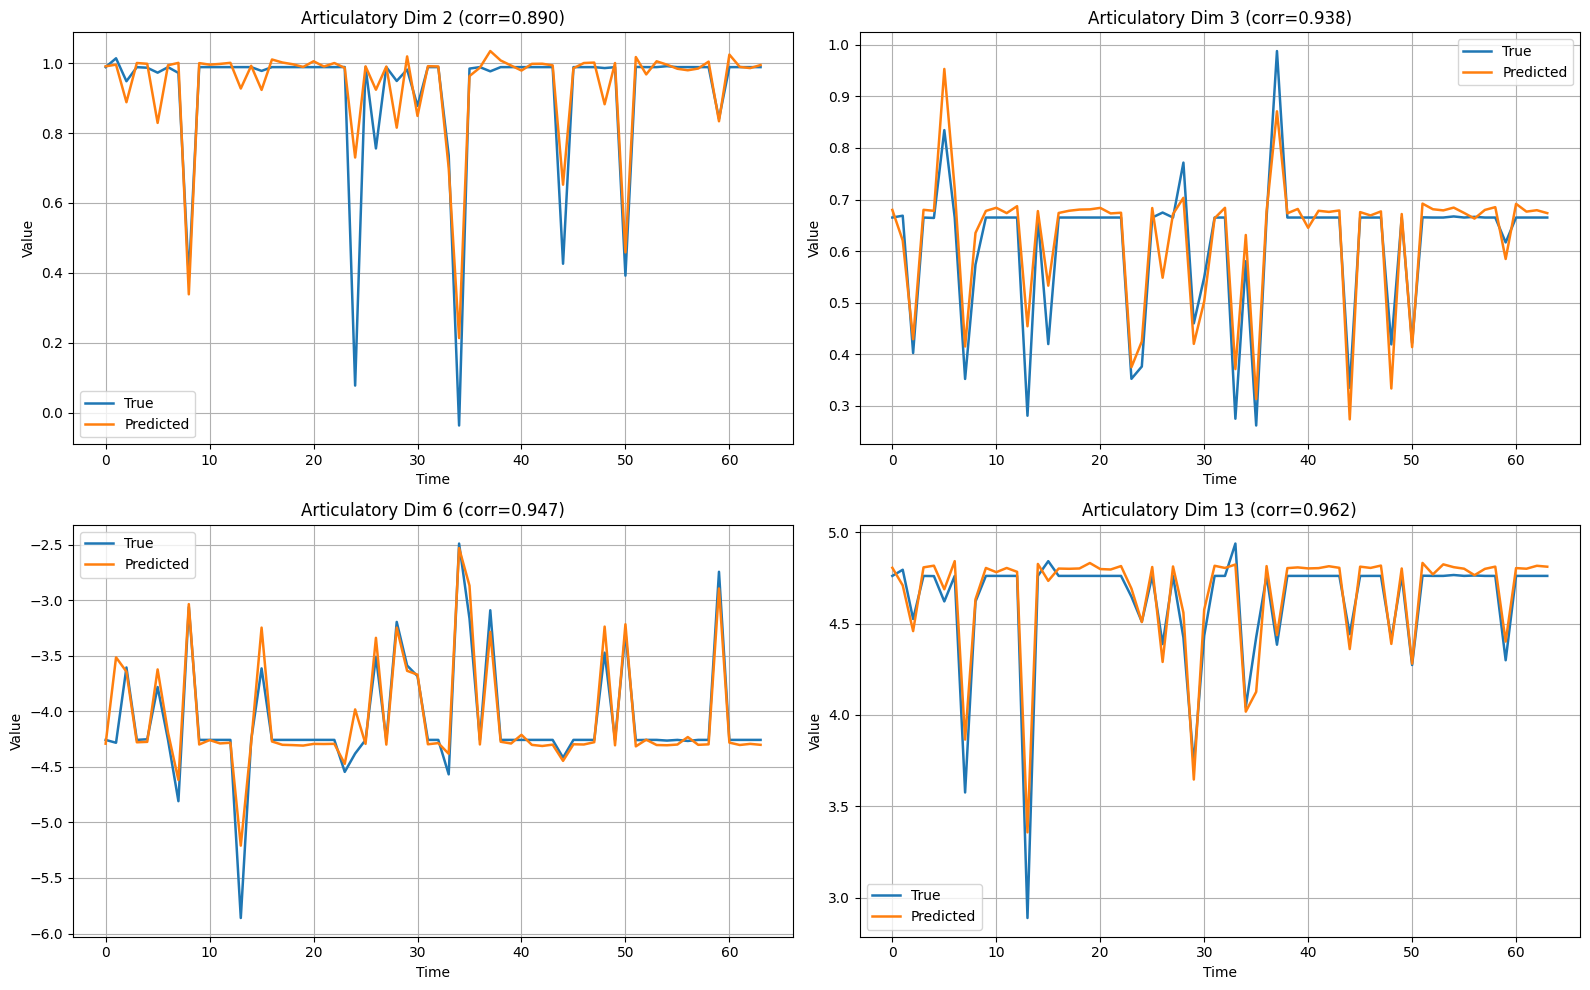

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

model.eval()

# =============================
# 1) Get a batch
# =============================
Xb, Yb = next(iter(val_loader))
Xb = Xb.to(device)

with torch.no_grad():
    output = model(Xb)

# Model may return (predictions, embeddings)
if isinstance(output, tuple):
    pred = output[0]
else:
    pred = output

true = Yb.numpy()
pred = pred.cpu().numpy()

print("Batch shapes → True:", true.shape, "Pred:", pred.shape)

# =============================
# 2) Plot selected dimensions
# =============================
dims_to_plot = [2, 3, 6, 13]

plt.figure(figsize=(16, 10))

for i, d in enumerate(dims_to_plot):
    plt.subplot(2, 2, i+1)

    plt.plot(true[:300, d], label="True", linewidth=1.8)
    plt.plot(pred[:300, d], label="Predicted", linewidth=1.8)

    corr = pearsonr(true[:, d], pred[:, d])[0]
    plt.title(f"Articulatory Dim {d} (corr={corr:.3f})")

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
save_path = "/content/articulatory_encoder_sub01.pth"
torch.save(model.state_dict(), save_path)
print("Saved articulatory encoder:", save_path)


Saved articulatory encoder: /content/articulatory_encoder_sub01.pth


In [ ]:
torch.save({
    "state_dict": model.state_dict(),
    "channels": channels,
}, "/content/articulatory_encoder_full_sub01.pth")


In [ ]:
# ================================
# INSPECT ARTICULATORY CHECKPOINT
# ================================

import torch, os

# Try to automatically detect saved .pt or .pth files
articulatory_files = [f for f in os.listdir() if f.endswith((".pt", ".pth"))]
print("Detected articulatory checkpoint files:", articulatory_files)

# If multiple files appear, pick the correct one manually
if len(articulatory_files) == 1:
    path = articulatory_files[0]
    print("\nLoading:", path)
    ckpt = torch.load(path, map_location="cpu")
    print("Checkpoint keys:", ckpt.keys())
else:
    print("\nPlease tell me which file is the correct checkpoint.")


Detected articulatory checkpoint files: ['articulatory_encoder_sub-01.pth', 'articulatory_encoder_sub-13.pth', 'articulatory_encoder_sub-08.pth', 'articulatory_encoder_sub-12.pth', 'articulatory_encoder_sub-06.pth', 'articulatory_encoder_sub-04.pth', 'articulatory_encoder_sub-11.pth', 'articulatory_encoder_sub01.pth', 'articulatory_encoder_sub-15.pth', 'articulatory_encoder_full_sub01.pth', 'articulatory_encoder_sub-05.pth', 'articulatory_encoder_sub-10.pth', 'articulatory_encoder_sub-03.pth', 'articulatory_encoder_sub-14.pth', 'articulatory_encoder_sub-07.pth', 'articulatory_encoder_sub-09.pth']

Please tell me which file is the correct checkpoint.
